In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import os.path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import sparse
import time

# load preprocessed data

In [0]:
# load pre-processed data
# replace with local file-path if you're running on local python shell
train_X= pd.read_csv('/content/drive/My Drive/1003 project - Yelp fake review/train_X.csv')
train_y= pd.read_csv('/content/drive/My Drive/1003 project - Yelp fake review/train_y.csv')
val_X = pd.read_csv('/content/drive/My Drive/1003 project - Yelp fake review/val_X.csv')
val_y = pd.read_csv('/content/drive/My Drive/1003 project - Yelp fake review/val_y.csv')


**remember, for the final test, train_val is our train, and test is our val**

In [0]:
train_X = pd.concat((train_X, val_X), axis=0).reset_index(drop=True)
train_y = pd.concat((train_y, val_y), axis=0).reset_index(drop=True)

val_X = pd.read_csv('/content/drive/My Drive/1003 project - Yelp fake review/test_X.csv')

Note that right now, the cleaned reviews are byte strings instead of normal strings, hence the `b' '` enclosing the string.


In [0]:
#add 2 new features: text length and word length. These are probably be useful
train_X['text length'] = train_X['review'].apply(len)
train_X['word length'] = train_X['review'].apply(lambda x: len(x.split(" "))) 

val_X['text length'] = val_X['review'].apply(len)
val_X['word length'] = val_X['review'].apply(lambda x: len(x.split(" ")))

# text length: the number of characters (including white spaces) in the string
# word length: the number of words in the string

In [25]:
train_X.head()

,ex_id,user_id,prod_id,rating,date,review,cleaned review,text length,word length
0,0,923,0,3.0,2014-12-08,The food at snack is a selection of popular Gr...,b'the food snack select popular greek dish the...,215,40
1,1,924,0,3.0,2013-05-16,This little place in Soho is wonderful. I had ...,b'this littl place soho wonder lamb sandwich g...,269,52
2,2,925,0,4.0,2013-07-01,ordered lunch for 15 from Snack last Friday. ...,b'order lunch snack last friday time noth miss...,178,32
3,3,926,0,4.0,2011-07-28,This is a beautiful quaint little restaurant o...,b'this beauti quaint littl restaur pretti stre...,491,90
4,4,927,0,4.0,2010-11-01,Snack is great place for a casual sit down lu...,b'snack great place casual sit especi cold win...,596,102


In [26]:
val_X.shape

(72165, 10)

In [27]:
train_X.shape

(286792, 9)

In [28]:
train_y.shape

(286792, 1)

## create good and fake user sets

In [0]:
# piece the X and label together
train = pd.concat((train_X, train_y), axis=1)


In [0]:
# create a dictionary where 
  # the key is each unique user_id in the trianing set
  # the value is their average label score rounded to 3 digits
user_dict = round(train.groupby('user_id')['label'].mean(), 3).to_dict()


In [0]:
# an average label value of 1 means the user always leaves fake reviews, and gets added to the fake_user list
# an average label value of 0 means the user always leaves real revies, and gets added to the good_user list

fake_user=[]
good_user=[]

for k in user_dict.keys():
  if user_dict[k] == 1:
    fake_user.append(k)
  if user_dict[k] == 0:
    good_user.append(k)


In [0]:
# a list of row indices in the val set that corresponds to a review left by a fake user
fake_rows = val_X['user_id'][val_X['user_id'].isin(fake_user)].index.tolist()

# a list of row indices that corresponds to a review left by a good user
good_rows = val_X['user_id'][val_X['user_id'].isin(good_user)].index.tolist()


# resampling train set only

In [0]:
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN

## ros upsample

In [0]:
# create a raondom sampler object from the class
ros = RandomOverSampler(random_state=0)

In [35]:
# create re-sampled data from the original data
# The augmented data set should be used instead of the original data set to train a classifier
train_X_ros, train_y_ros = ros.fit_sample(train_X, train_y)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [0]:
# on local python shell, the trian_X_ros after oversampling is still DataFrame
# But on colab version it turned to array, so we need to change it back to a pd.df
train_X_ros = pd.DataFrame(train_X_ros, columns = ['ex_id','user_id','prod_id','rating','date','review','cleaned review','text length','word length'])
train_y_ros = pd.DataFrame(train_y_ros, columns = ['label'])

In [37]:
print('pre-upsampling genuine cases: ',train_y[train_y['label'] == 0].shape[0])
print('post-upsampling genuine cases: ',train_y_ros[train_y_ros['label'] == 0].shape[0])
print()
print('pre-upsampling fake cases: ',train_y[train_y['label'] == 1].shape[0])
print('post-upsampling fake cases: ',train_y_ros[train_y_ros['label'] == 1].shape[0])

pre-upsampling genuine cases:  257325
post-upsampling genuine cases:  257325

pre-upsampling fake cases:  29467
post-upsampling fake cases:  257325


now, the number of fake reviews is the same as the number of genuine reviews. We have fixed the class-imbalance issue.

# Text to vector conversion

## 3 extra feature columns for train and validation

In [0]:
# let's add the additional features to the training matrix
train_extra = np.array(train_X_ros[['text length','word length','rating']], dtype=float)

# normalize the extra features
train_extra_min = train_extra.min(axis = 0) # get the min value for each column
train_extra_max = train_extra.max(axis = 0) # get the max value for each column
train_extra = (train_extra - train_extra_min)/(train_extra_max-train_extra_min) # normalize each column to be between 0~1


In [0]:
# do the same for the validation X data

# let's add the additional features to the validation matrix
val_extra = np.array(val_X[['text length','word length','rating']], dtype=float)

# normalize the extra features
val_extra_min = val_extra.min(axis = 0) # get the min value for each column
val_extra_max = val_extra.max(axis = 0) # get the max value for each column
val_extra = (val_extra - val_extra_min)/(val_extra_max-val_extra_min) # normalize each column to be between 0~1



## TF-IDF

From the linear SVM implementation below, we can see that our `au_roc` score is very poor, almost the same as our Naive Bayes baseline model. We can guess that is because our word-vectors are not linearly separable in their 70000+ dimension space. Can we try to use TF-IDF and present them as vectors in a different way that makes the vectors more separable? This is why we want to try to use TF-IDF to represent our text. 

TF-IDF is an acronym than stands for “Term Frequency — Inverse Document” Frequency which are the components of the resulting scores assigned to each word. 

Term Frequency: This summarizes how often a given word appears within a document.

Inverse Document Frequency: This down scales words that appear a lot across documents.

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [0]:
# create an object from class
# by default, TfidfVectorizer uses ’utf-8’ as the encoding to decode byte texts, which is the encoding used in our processed text
tfidf_vect = TfidfVectorizer()

In [0]:
# # learn (fit) the vocab dictionry from the entire data! not just the train!
# tfidf_vect.fit(pd.concat([train_X_ros['cleaned review'], val_X['cleaned review']]))

In [0]:
# learn (fit) the vocab dictionry and vetorize (transform) each review
tfidf_train_X = tfidf_vect.fit_transform(train_X_ros['cleaned review'])
# this returns a sparse matrix where each row represent a review
# this is no longer a dataframe!

In [44]:
tfidf_train_X

<514650x78888 sparse matrix of type '<class 'numpy.float64'>'
	with 22808222 stored elements in Compressed Sparse Row format>

We can see that the matrix has the number of reviews as rows and 73944 unique words in all reviews, same as our BoW of course.

we also have to trasnform our validation set but be careful, we cannot train the vectorizer on the validation set, because after training, our model only knows how to classify inputs that has the same # of features. So if we had fit our vectorizer on the validation set, it might result in a matrix with different numbers of features.

In [0]:
tfidf_val_X = tfidf_vect.transform(val_X['cleaned review'])

In [46]:
tfidf_val_X

<72165x78888 sparse matrix of type '<class 'numpy.float64'>'
	with 3654958 stored elements in Compressed Sparse Row format>

Similarly, add the 3 additioanl feature columns to the sparse matrix for both train and validation input.

In [47]:
# add these columns to our tfidf matrix, remember to keep the sparse format
tfidf_train_X_extra = sparse.hstack((tfidf_train_X, train_extra))
tfidf_train_X_extra

<514650x78891 sparse matrix of type '<class 'numpy.float64'>'
	with 24316659 stored elements in COOrdinate format>

In [48]:
# add these columns to our tfidf matrix, remember to keep the sparse format
tfidf_val_X_extra = sparse.hstack((tfidf_val_X, val_extra))
tfidf_val_X_extra

<72165x78891 sparse matrix of type '<class 'numpy.float64'>'
	with 3868576 stored elements in COOrdinate format>

# Best linear model (SVM) training

In [0]:
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import roc_curve, auc, roc_auc_score, average_precision_score, confusion_matrix
from sklearn.kernel_approximation import Nystroem

In [50]:
# change the y-labels from dataframe to ndarray of shape (n_samples, ) for model inputs
train_y_ros_arr = np.array(train_y_ros['label'])
print(train_y_ros_arr.shape)

val_y_arr = np.array(val_y['label'])
print(val_y_arr.shape)

(514650,)
(35918,)


In [0]:
# create a function to print all the results in one place

def get_results(y_true, y_pred, y_score):
  '''
  Params:
  -------------------------------------
  y_true: ndarray of shape (n_samples, ) of true class labels \n
  y_pred: ndarray of shape (n_samples, ) of predicted class labels used for confusion matrix \n
  y_score: ndarray of shape (n_samples, ) of predicted confidence scores used for au_ROC and AP 
  '''

  print('au_roc score:', roc_auc_score(y_true, y_score))
  print('average precision score:', average_precision_score(y_true, y_score))

  plt.plot([0, 1], [0, 1], 'k--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.0])
  plt.xlabel('FPR')
  plt.ylabel('TPR')
  plt.title('ROC')

  fpr, tpr, thresholds = roc_curve(y_true, y_score)
  curve = plt.plot(fpr, tpr, label = 'SVM' + ' (AUC = %0.3f)' % roc_auc_score(y_true, y_score))
  plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

  plt.show()

  print()
  print('Confusion Matrix:')
  print(pd.DataFrame(confusion_matrix(y_true, y_pred), index=['actual negative', 'actual positive'], 
             columns=['predicted negative', 'predicted positive']))
  
  return

In [0]:
# create SGDclassifier object using the best model
sgd = SGDClassifier(random_state=1,
                    alpha = 1e-05,
                    early_stopping = True,
                    loss = 'hinge',
                    penalty = 'l2',
                    tol = 0.01)

In [53]:
# fit the model to our training data
sgd.fit(tfidf_train_X_extra, train_y_ros_arr)

SGDClassifier(alpha=1e-05, average=False, class_weight=None,
              early_stopping=True, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=1, shuffle=True, tol=0.01,
              validation_fraction=0.1, verbose=0, warm_start=False)

### in-sample score

au_roc score: 0.7967371591953546
average precision score: 0.7631734804122228


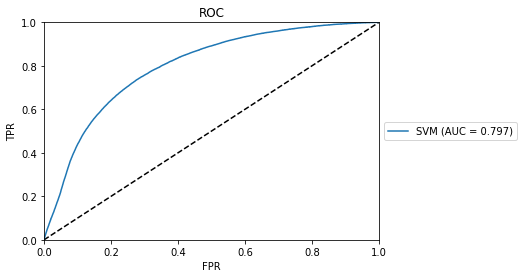


Confusion Matrix:
                 predicted negative  predicted positive
actual negative              180918               76407
actual positive               63235              194090


In [54]:
# evalute the best model on the actual validation set
train_pred = sgd.predict(tfidf_train_X_extra)
# this returns a ndarray of shape (n_samples, )

# predict the confidence score for our validation set
train_score = sgd.decision_function(tfidf_train_X_extra)
# this returns a ndarray of shape (n_samples, )

get_results(train_y_ros_arr, train_pred, train_score)

In [55]:
train_score.min()

-5.005579303592162

In [56]:
train_score.max()

3.4172370620524637

From this, we can see that the most confident negative classes (real reviews) gets a score of about -5, and the most confident positive classes (fake reviews) gets a score of about 3.

## out-of-sample decision score

In [0]:
# predict the labels for our validation set
val_pred = sgd.predict(tfidf_val_X_extra)
# this returns a ndarray of shape (n_samples, )

# predict the confidence score for our validation set
val_score = sgd.decision_function(tfidf_val_X_extra)
# this returns a ndarray of shape (n_samples, )

can't get validation evaluations b/c we don't have the tru labels now.

## reinforced validation score

In [0]:
# reinforce the decision function score using dummy classifier
val_score[fake_rows] = 4
val_score[good_rows] = -6

In [64]:
val_score

array([-0.87664237, -0.26399454, -6.        , ..., -6.        ,
        0.05258996, -6.        ])

In [72]:
val_score.shape

(72165,)

In [0]:
np.savetxt('/content/drive/My Drive/1003 project - Yelp fake review/cc_score.csv', val_score, 
           delimiter=",", header = ' ')

In [78]:
final_score = pd.read_csv('/content/drive/My Drive/1003 project - Yelp fake review/cc_score.csv')
final_score

,#
0,-0.876642
1,-0.263995
2,-6.000000
3,0.017421
4,-6.000000
...,...
72160,-6.000000
72161,-0.850368
72162,-6.000000
72163,0.052590
